Irregularly spaced time steps



In [1]:
from rnn import *
from shopgen_irreg import *
from tqdm import tqdm_notebook as tn
from tqdm import tqdm, trange
import sklearn.metrics

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt



Generate Data First

### Generate a Mixture of user-types (or sequence-types)

Problem -- with variable-length sequences, for each batch the sequences are packed in decreasing order,
how do we stack/concatenate multiple variable-length batches?

In [2]:
future = 20
nt = 500
nb = 00

g = shopgen_irreg(carts=3, win=20, infwin=5, future=future, prob = 0.7, mean_lag = 5)

btrain1 = g.gen_tensors(nt=nt, nb=nb, minlen = 1.0, fill = 'rand', gpu = False, xhot=True)

g = shopgen_irreg(carts=6, win=20, infwin=15, future=future, prob = 0.7, mean_lag = 5)

btrain2 = g.gen_tensors(nt=nt, nb=nb, minlen = 1.0, fill = 'rand', gpu = False, xhot=True)

# carter
g = shopgen_irreg(carts=4, win=30, infwin=15, future=future, prob = 0.1, mean_lag = 20)

btrain3 = g.gen_tensors(nt=nt, nb=nb, minlen = 1.0, fill = 'rand', gpu = False, xhot=True)



##

x = t.cat( [btrain1.x, btrain2.x, btrain3.x],  1  )
y = t.cat( [btrain1.y, btrain2.y, btrain3.y],  1  )

nb = x.size()[1]


indices = t.LongTensor(np.random.permutation(range(nb)))

x = t.index_select(x, 1, indices).cuda()
y = t.index_select(y, 1, indices).cuda()

nt = x.size()[0]
ntrain = int(4*nb/5)

xtrain, ytrain = x[:, :ntrain, :], y[:, :ntrain, :]
xtest, ytest = x[:, ntrain:, :], y[:, ntrain:, :]

lengths = -np.sort(-np.random.random_integers(int(nt * 0.3), nt, ntrain))




/home/ubuntu/src/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: DeprecationWarning: This function is deprecated. Please call randint(150, 500 + 1) instead


<IPython.core.display.Javascript object>


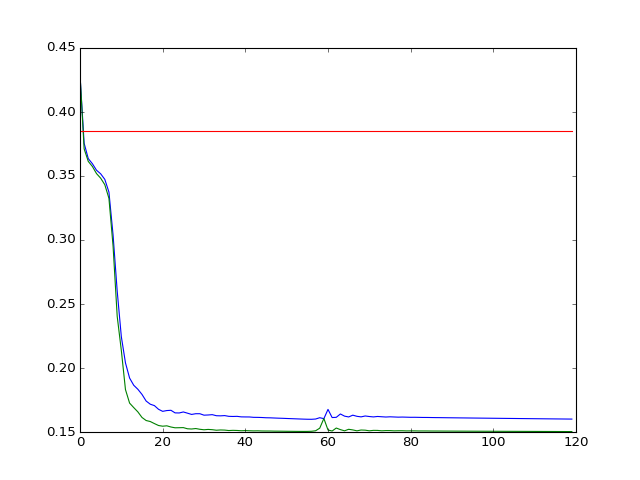

emp loss = 0.384958496401
val loss =  0.150333151221
train auc = 0.962422054027
val   auc = 0.96630131729


In [3]:


# best settings:
#model = RNN(rnn_type ='GRU', nf=2, nh=25, nlay=3, dropout = 0.5)
#model = RNN(rnn_type ='GRU', nf=2, nh=10, nlay=1, dropout = 0.1) # BEST!! final test loss = 0.48
#model = RNN(rnn_type ='LSTM', nf=2, nh=16, nlay=1, dropout = 0.0) # 0.47 !

model = RNN(rnn_type ='GRU', nf=4, nh=30, nlay=1, dropout = 0.0) # best for diff_data !!! use Adam lr = 5e-4



#loss_fn = nn.MSELoss(size_average=True)
loss_fn = nn.BCELoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr = 0.01)
#optimizer = optim.Adagrad(model.parameters(), lr = 0.1)
#optimizer = optim.Adam(model.parameters(), lr = 0.7)
#optimizer = optim.RMSprop(model.parameters(), lr = 0.001)
model.zero_grad()



#xtrain, ytrain, lengths, xtest, ytest, test_lens = make_diff_data(15, 1000, 1, 3, gpu = True)

#xtrain, ytrain, lengths, xtest, ytest, test_lens = make_r2rt_data(30, 1000, 1, gpu = True, xhot = True)
## manually run model a few iterations 
model.cuda()

bsiz = 100 # mini-batch size
nb = xtrain.size()[1]/bsiz  # how many mini-batches per epoch

nepochs = 120
loss = 1.0
#epoch_range = trange(nepochs, desc='Loss', leave=True)

p = (ytest.sum()/(ytest*0 + 1).sum())
emp_loss = -p*np.log(p)-(1-p)*np.log(1-p)

points = np.repeat(None, nepochs) # train losses
val_points = np.repeat(None, nepochs) # validation losses
emp_points = np.repeat(emp_loss, nepochs) 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
for p in model.parameters():
    if p.ndimension() < 2:
        nn.init.normal(p)
    else:
        nn.init.xavier_uniform(p)
    
    
for epoch in range(nepochs):
    for batch in range(nb):
        bStart = batch * bsiz
        bEnd = min(xtrain.size()[1], (batch + 1)*bsiz)
        
        hidden = model.init_hidden(bsiz)
        hidden = repackage_hidden(hidden)
        
        model.zero_grad()
        optimizer.zero_grad()
        

        batch_x = xtrain[:, bStart : bEnd, :]
        batch_lengths = lengths[bStart : bEnd]
        batch_x_packed = rnn_utils.pack_padded_sequence(Variable(batch_x), batch_lengths)
        y_pred, hidden = model(batch_x_packed, hidden)
                
        batch_y = rnn_utils.pack_padded_sequence(Variable(ytrain[:, bStart : bEnd, :]), batch_lengths)
        

        # CAUTION -- y_pred is BATCH-WISE, i.e. b
        # batch 0 for ALL sequences, then
        # batch 2 for ALL sequences, etc.
        # target = ytrain.squeeze()[:, bStart:bEnd].contiguous().view(-1, 1)
        loss = loss_fn(y_pred, batch_y.data)
        # optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # tqdm.write('loss = ' + str(loss.data[0]))
    points[epoch] = loss.data[0]  
    ypred_val = model(Variable(xtest), None)[0]
    val_loss = loss_fn(ypred_val, Variable(ytest)).data[0]
    val_points[epoch] = val_loss
    ax.clear()
    ax.plot(points)
    ax.plot(val_points)
    ax.plot(emp_points)
    fig.canvas.draw()
#     epoch_range.set_description("Loss %4.3f" % loss.data[0])
#     epoch_range.refresh() # to show immediately the update




ypred = y_pred.data.squeeze().cpu().numpy()
ylabel = batch_y.data.data.cpu().numpy()
auc_train = sklearn.metrics.roc_auc_score(ylabel, ypred)

yt = ytest.squeeze().cpu().numpy().flatten()
ypred_val = model(Variable(xtest), None)[0]
ypv = ypred_val.data.squeeze().cpu().numpy()
auc_val = sklearn.metrics.roc_auc_score(yt, ypv)

print 'emp loss =', emp_loss
print 'val loss = ', val_loss

print 'train auc =', auc_train
print 'val   auc =', auc_val



# print 'y,pred = ', zip(batch_y.data.squeeze()[:ny].data.cpu().numpy(), y_pred.data.squeeze()[:ny].cpu().numpy())


### Use the learned rnn to do some interesting things

1. Create just one sequence and pass it through model, or model.rnn



In [ ]:
x, y, emp = g.gen_xy(40)
xevs, xlags = zip(*x)

tx_events = one_hot(t.Tensor(xevs).view(-1,1,1))
tx_lags = t.Tensor(xlags).view(-1,1,1)
tx = t.cat([tx_events, tx_lags], 2)
my, _ = model(Variable(tx.cuda()), None)
my = my.data.cpu().numpy().flatten()
np.transpose(np.stack([xevs,xlags,y,my]))






In [ ]:

sklearn.metrics.roc_auc_score(y, my)


### Verify last hidden layer

We want to show:
Pred(None, <x_1, x_2, ..., x_k>) = Pred(H_{k-1}, x_k)

where H_{k-1} is hidden layer after seeing `<x_1, x_2, ..., x_{k-1}>`



In [ ]:
my[20]

In [ ]:
tx_all = tx[:20,:,:]
# full thing

y, hid_last =  model(Variable(tx_all.cuda()), None)

# all but last
tx_butlast = tx_all[:-1,:,:]
_, hid_butlast = model(Variable(tx_butlast.cuda()), None)

# use hid state from all-but-last above, and feed in last x
tx_last = tx_all[-1:, :, :]
y_last, _ = model(Variable(tx_last.cuda()), hid_butlast)

# compare
(y[-3:], y_last)




In [ ]:
yt = ytest.squeeze().cpu().numpy().flatten()
ypred_val = model(Variable(xtest), None)[0]
ypv = ypred_val.data.squeeze().cpu().numpy()
sklearn.metrics.roc_auc_score(yt, ypv)


In [ ]:

ypred = y_pred.data.squeeze().cpu().numpy()
ylabel = batch_y.data.data.cpu().numpy()
sklearn.metrics.roc_auc_score(ylabel, ypred)

In [ ]:
ytrain[:15, 0,0]
